In [376]:
# General stuff
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.patches import Circle, Ellipse, Rectangle
import seaborn as sns

# Astropy stuff
from astropy.io import fits, ascii
from astropy.visualization import simple_norm  # this will come in handy to visualize images
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import table
import astropy.units as u

# For calculating flux
import sep

# Fitting stuff
from scipy import stats
from scipy.optimize import curve_fit
import General_functions as my

# For convolving
import warnings
from astropy.modeling.models import Sersic2D
from scipy.signal import fftconvolve as fft

# For creating loading bars
from tqdm.notebook import tqdm

# Import datasets, classifiers and performance metrics
from sklearn import datasets, manifold, metrics, preprocessing, utils
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.spatial.distance import cdist
from matplotlib.patches import ConnectionPatch

# Load tables and images

In [2]:
# Opening the IRAC ch1 image
def open_img(filename, hdu=0):
    
    if filename[-5:] == '.fits':  
        # if last 5 characters of the string are '.fits', the file is interpreted as FITS file
        hdul = fits.open(filename)  # open the HDU list of a FITS file 
                                    # (it may contain multiple data sets called Header Data Units)
            
        img = hdul[hdu].data  # save data from the unit n. 1 (or whatever is the `hdu` nuber) into `img` array
        hdr = hdul[hdu].header  # we may need also the header, which contain info about the image/data set
        # .header
        hdul.close()  # close the FITS file
        
    else:
        # if not FITS file, the function complains because it doesn't know other ways to do
        sys.exit("ERROR: open_img can deal with FITS file only.")
        
    return img, hdr  # the output is a tuple of two different objects

In [3]:
# Load IRAC ch1 image and residual image from ch1 + ch2
img, hdr = open_img('Resources/IRAC_ch1.fits', hdu=0)

In [4]:
# Load COSMOS catalogue
cosmos_tab = table.Table.read("Resources/COSMOS2020_CLASSIC_v1.5_formatted.fits",format="fits")

In [5]:
# Load residual catalogue
resi_tab = table.Table.read('Resources/irac-resid_v2_comb.fits', format='fits')

In [6]:
# Load catalogue with labels
labels_tab = table.Table.read('Resources/irac-resid_v2_visual-class.fits', format='fits')

# Plot a few objects, IRAC image and different vignettes
First we need to match coordinates of the cosmos_tab (to find objects in IRAC) with coordinates of resi_tab

In [7]:
#Sky matching function (adjusted so my_skycoord should be a SkyCoord class)
def match_cat(my_coord, cat_coord, r=1):

    # SkyCoord eats numbers with units.
    # This function assumes input coordinates are in decimal degree
    import astropy.units as u
    my_skycoord = SkyCoord(ra = my_coord[0], dec = my_coord[1], unit='deg')
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg')
    
    idx, d2d, _ = match_coordinates_sky(my_skycoord, cat_skycoord)
    max_sep = r*u.arcsec
    sep_limit = d2d < max_sep
    #sep_limit not only the mask for selecting objects within the 2nd sample, but by itself can be used to select in the 1st sample.
    return sep_limit, idx[sep_limit]

We make sure that the coordinates from the catalogue are actually within the tile we are working with

In [8]:
# Load information from the tile's header
w = WCS(hdr)

# corner values on shape [y,x] for img
y_lim, x_lim = np.shape(img)

# Find pixel values in the image's corner (notice this is on the form x,y as in DS9 and not like imshow shows)
bottom_left = (11,11)
bottom_right = (x_lim-11, 11)
upper_left = (11, y_lim-11)
upper_right = (x_lim-11, y_lim-11) # We remove 11 pixels from border so we can always make 21x21 size cutouts

# Find RA DEC coordinates for these
corners = [bottom_left, bottom_right, upper_left, upper_right]
sky_corners = []

for i in range(4):
    skycoord = w.pixel_to_world(*corners[i])
    print(skycoord)
    sky_corners.append(skycoord) 

<SkyCoord (ICRS): (ra, dec) in deg
    (151.0623357, 1.29133181)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.05920166, 1.29128805)>
<SkyCoord (ICRS): (ra, dec) in deg
    (151.0636075, 3.29393279)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.05778055, 3.29382107)>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [9]:
# The interval of right ascension is thus:
ra_int = (149.05920166, 151.0623357)

# Declination interval
dec_int = (1.29133181, 3.29393279) #change later

# Lets mask the cosmos catalogue to create a new catalogue containing only sources within the image
mask = (cosmos_tab['ALPHA_J2000'] > ra_int[0]) & (cosmos_tab['ALPHA_J2000'] < ra_int[1]) \
        & (cosmos_tab['DELTA_J2000'] > dec_int[0]) & (cosmos_tab['DELTA_J2000'] < dec_int[1])
match_cosmos = cosmos_tab[mask]

In [10]:
# Extract coordinates RA, DEC
cosmos_coord = [ match_cosmos['ALPHA_J2000'], match_cosmos['DELTA_J2000'] ] #no coordinates specific for IRAC in tab
resi_coord = [ resi_tab['ALPHA_J2000'], resi_tab['DELTA_J2000'] ] #same

# Get indices of matching objects
resi_idx, cosmos_idx = match_cat(resi_coord, cosmos_coord)

# Print number of matched objects
print('No. of matched objects:', np.sum(resi_idx))

No. of matched objects: 653


# Load t-SNE embedding from the other notebook

In [12]:
# Save the embedding so we dont have to run it again
import pickle
with open('Saved_Results/embedding.pickle', 'rb') as f:
    X_tsne_arr = pickle.load(f)

In [13]:
np.shape(X_tsne_arr)

(9, 3139, 2)

This is the right size, there was 9 different perplextities used therefor there are 9 embedding stored. Each with 3139 samples with 2 coordinates.

## Labeling color with blue and red udefined color marked separetly

In the previous notebook we calculated the colors and plotted them. In case we need to use that later, lets save the color arrays here.

In [14]:
# Define colors myself
uvista = 30
irac = 21.58

# Calculate magnitudes in each band
mag_H =  -2.5*np.log10(resi_tab['FLUX_APER_H'][:,0]) + uvista
mag_Ks = -2.5*np.log10(resi_tab['FLUX_APER_Ks'][:,0]) + uvista
mag_ch1 = -2.5*np.log10(resi_tab['FLUX_APER_ch1'][:,0]) + irac
mag_ch2 = -2.5*np.log10(resi_tab['FLUX_APER_ch2'][:,0]) + irac

# Calculate colors (including Nan, we will plot over these anyways)
H_Ks = mag_H - mag_Ks
Ks_ch1 = mag_Ks - mag_ch1
ch1_ch2 = mag_ch2 - mag_ch1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


# Choosing perplexity 40 and labeling (i) Robust candidates, (ii) Matched objects and (iii) Bright objects

Lets make a plot visualising the embedding while marking 3 regions, from which we can show examples of cutouts. First we will extract the t-SNE coordinates belonging to perplexity 40, afterwards we need to make masks that can extract the objects from the different regions. Bright objects are nicely seperated and therefor doesnt have to be found from a requirement on the flux in the catalogue although we can select them from the embedding and report the minimum flux present in the group.

In [15]:
# Extract the embedding of perplexity 40 from the array of all embeddings
X_tsne = X_tsne_arr[5]

In [85]:
# Select all objects in resi_tab that are labelled "O" in the NOTES column in labels_tab
O_mask = (labels_tab['NOTES']=='O ')

# Extract the numbers from the list
O_numbers = labels_tab[O_mask]['NUMBER']
print(f'There are {len(O_numbers)} galaxies denoted O: the most interesting ones for our purpose')

# Make a mask for the resi_tab that is 1 (True) for 'O' and 0 (False) for the rest
O_resi_mask = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] in O_numbers:
        O_resi_mask[i] = int(1)
    
    else:
        O_resi_mask[i] = int(0)
        
# Do the same for K
K_mask = (labels_tab['NOTES']=='K ')

# Extract the numbers from the list
K_numbers = labels_tab[K_mask]['NUMBER']
print(f'There are {len(K_numbers)} galaxies denoted K: the next interesting ones for our purpose')

# Make a mask for the resi_tab that is 1 (True) for 'O' and 0 (False) for the rest
K_resi_mask = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] in K_numbers:
        K_resi_mask[i] = True
    
    else:
        K_resi_mask[i] = False
        
# Make a mask that includes all labeled O or K
labeled_mask = O_resi_mask + K_resi_mask

There are 62 galaxies denoted O: the most interesting ones for our purpose
There are 71 galaxies denoted K: the next interesting ones for our purpose


In [103]:
# Mask selecting the objects in the little cluster we deem to be the bright galaxies
bright_mask = (X_tsne[:,0]>55) #we make the selection from what we have seen in the embedding

# Mask selecting the significant outliers (far from the clustering)
outlier_mask = (X_tsne[:,0]<-80)

We need to select the four objects for which we will show the telescope cutout image in each band

In [190]:
##### Select objects
coords1 = X_tsne[outlier_mask][0]
coords2 = X_tsne[labeled_mask][20]
coords3 = X_tsne[bright_mask][20]
coords4 = X_tsne[resi_idx][50]

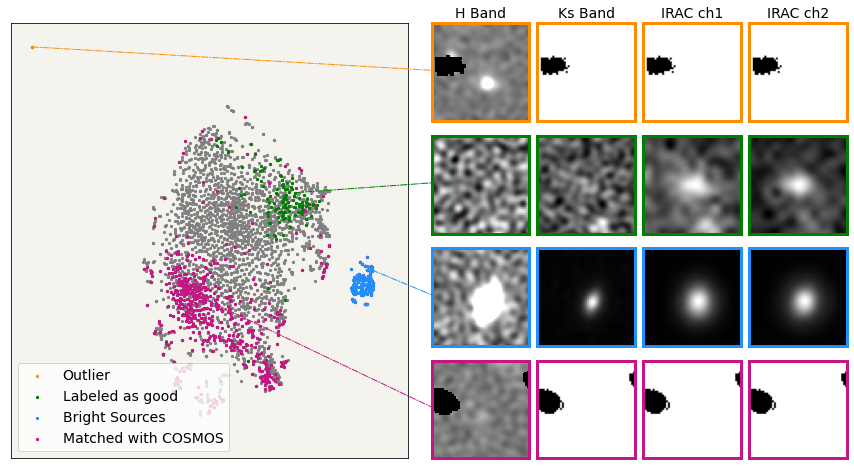

In [407]:
# Create figure ------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(15, 8))

# Colors to use
clrs = ['darkorange', 'green', 'dodgerblue', 'mediumvioletred']

# Specifics
rows = 4
columns = 6

# Create figure grid
grid = plt.GridSpec(rows, columns, figure=fig, wspace = .05, hspace = .15, width_ratios=[4,0.1,1,1,1,1])

# Create main plot for the t-SNE embedding and the three regions
tsne_ax = plt.subplot(grid[:, 0])
tsne_ax.set(xlim=(-120,90), ylim=(-60,70), xticks=([]), yticks=([]))
tsne_ax.set_facecolor('#f4f3ee')

# Make subplots for the cutouts of the galaxies
axes = []

# Loop over rows (galaxy examples)
for i in range(rows):
    
    ax_i = []
    
    # Loop over columns (telescope bands)
    for j in range(columns-2):
        
        # Make subplot
        ax = plt.subplot(grid[i, j+2])
        
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax_i.append(ax)
    
    # Append axes on the form (row, column) for all the smaller subplots
    axes.append(ax_i)

# Columns labels
axes[0][0].set_title('H Band', fontsize=14)
axes[0][1].set_title('Ks Band', fontsize=14)
axes[0][2].set_title('IRAC ch1', fontsize=14)
axes[0][3].set_title('IRAC ch2', fontsize=14)
    
# Plot embedding ----------------------------------------------------------------------------------------

# Plot all points
tsne_ax.scatter(X_tsne[:,0], X_tsne[:,1], s=5, c='grey')

# Plot labelled objects - promising candidates according to Iary's visual inspection
tsne_ax.scatter(X_tsne[:,0][outlier_mask], X_tsne[:,1][outlier_mask], c=clrs[0], s=5, 
                label='Outlier')

# Plot labelled objects - promising candidates according to Iary's visual inspection
tsne_ax.scatter(X_tsne[:,0][labeled_mask], X_tsne[:,1][labeled_mask], c=clrs[1], s=5, 
                label='Labeled as good')

# Plot labelled objects - promising candidates according to Iary's visual inspection
tsne_ax.scatter(X_tsne[:,0][bright_mask], X_tsne[:,1][bright_mask], c=clrs[2], s=5, 
                label='Bright Sources', zorder=2)

# Plot matched objects
tsne_ax.scatter(X_tsne[:,0][resi_idx], X_tsne[:,1][resi_idx], c=clrs[3], s=5, 
                label='Matched with COSMOS')

# Add labels
tsne_ax.legend(loc='lower left', prop={'size': 14})

# Plot cutouts  -----------------------------------------------------------------------------------------

# Outlier
H_min, H_max = np.min(resi_tab['VIGNET_H'][labeled_mask][20]), np.max(resi_tab['VIGNET_H'][labeled_mask][20])
axes[0][0].imshow(resi_tab['VIGNET_H'][outlier_mask][0], 
                  cmap='gray', origin='lower', vmin=H_min, vmax=H_max)
axes[0][1].imshow(resi_tab['VIGNET_Ks'][outlier_mask][0], 
                  cmap='gray', origin='lower')
axes[0][2].imshow(resi_tab['VIGNET_ch1'][outlier_mask][0], 
                  cmap='gray', origin='lower')
axes[0][3].imshow(resi_tab['VIGNET_ch2'][outlier_mask][0], 
                  cmap='gray', origin='lower')

# Good
axes[1][0].imshow(resi_tab['VIGNET_H'][labeled_mask][20], 
                  cmap='gray', origin='lower', vmin=H_min, vmax=H_max)
axes[1][1].imshow(resi_tab['VIGNET_Ks'][labeled_mask][20], 
                  cmap='gray', origin='lower')
axes[1][2].imshow(resi_tab['VIGNET_ch1'][labeled_mask][20], 
                  cmap='gray', origin='lower')
axes[1][3].imshow(resi_tab['VIGNET_ch2'][labeled_mask][20], 
                  cmap='gray', origin='lower')

# Bright
axes[2][0].imshow(resi_tab['VIGNET_H'][bright_mask][20], 
                  cmap='gray', origin='lower', vmin=H_min, vmax=H_max)
axes[2][1].imshow(resi_tab['VIGNET_Ks'][bright_mask][20], 
                  cmap='gray', origin='lower')
axes[2][2].imshow(resi_tab['VIGNET_ch1'][bright_mask][20], 
                  cmap='gray', origin='lower')
axes[2][3].imshow(resi_tab['VIGNET_ch2'][bright_mask][20], 
                  cmap='gray', origin='lower')

# Matched
axes[3][0].imshow(resi_tab['VIGNET_H'][resi_idx][20], 
                  cmap='gray', origin='lower', vmin=H_min, vmax=H_max)
axes[3][1].imshow(resi_tab['VIGNET_Ks'][resi_idx][20], 
                  cmap='gray', origin='lower')
axes[3][2].imshow(resi_tab['VIGNET_ch1'][resi_idx][20], 
                  cmap='gray', origin='lower')
axes[3][3].imshow(resi_tab['VIGNET_ch2'][resi_idx][20], 
                  cmap='gray', origin='lower')

# Change color of frame --------------------------------------------------------------------------------
for i in range(4):
    for ax in axes[i]:
        for spine in ax.spines.values():
            spine.set_edgecolor(clrs[i])
            spine.set_linewidth(3)

# Plot lines connecting from dots to cutouts ------------------------------------------------------------
line1 = ConnectionPatch(xyA=coords1, coordsA=tsne_ax.transData, xyB=(0,26), coordsB=axes[0][0].transData,
                       color=clrs[0], linestyle='-.', zorder=2)
line2 = ConnectionPatch(xyA=coords2, coordsA=tsne_ax.transData, xyB=(0,26), coordsB=axes[1][0].transData,
                       color=clrs[1], linestyle='-.', zorder=2)
line3 = ConnectionPatch(xyA=coords3, coordsA=tsne_ax.transData, xyB=(0,26), coordsB=axes[2][0].transData,
                       color=clrs[2], linestyle='-.', zorder=2)
line4 = ConnectionPatch(xyA=coords4, coordsA=tsne_ax.transData, xyB=(0,26), coordsB=axes[3][0].transData,
                       color=clrs[3], linestyle='-.', zorder=2)
fig.add_artist(line1)
fig.add_artist(line2)
fig.add_artist(line3)
fig.add_artist(line4)

# Save figure
#plt.savefig('Saved_Figures/Visual_inspection_embedding.pdf')

plt.show()

(array([341., 330., 246., 163.,  98.,  60.,  43.,  20.,  26.,  17.]),
 array([-1.e-30,  1.e-01,  2.e-01,  3.e-01,  4.e-01,  5.e-01,  6.e-01,
         7.e-01,  8.e-01,  9.e-01,  1.e+00], dtype=float32),
 <BarContainer object of 10 artists>)

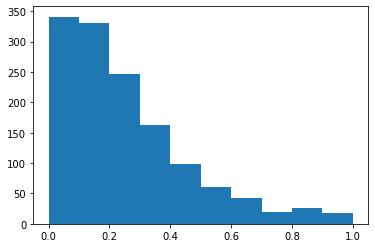

In [410]:
plt.hist(resi_tab['VIGNET_H'][resi_idx][20].flatten(),range=(-1*1e-30,1))

# Define train set and validation set

When visually inspecting the sources and providing labels, the worst candidates simply were not included in the table. Therefor we will now label the bad candidates as those that were not included in the labels from visual inspection.

We have to use some of the labels for what I call training: the labels that the K voting algorithm will know, and thus the objects that have a right to vote. We will also have some validation data: objects where WE actually know the labels but the algorithm don't. The code will produce a prediction (good or bad object) based on the train data, we can compare these to the actual labels that WE know, to evaluate the performance of the model.

There is also a significant amount of data we don't know anything about. We will still produce predictions, although we are not able to evaluate the performance.

In [249]:
# First find all the bad candidates i.e. those not in labels_tab
print(f'We will labels {len(resi_tab) - len(labels_tab)} as bad candidates')

bad_mask_all = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] not in labels_tab['NUMBER']:
        bad_mask_all[i] = 1
    else:
        bad_mask_all[i] = 0
        
bad_objects_all = resi_tab[bad_mask_all]

print(f'We found {len(bad_objects_all)} bad candidates')

We will labels 2948 as bad candidates
We found 2948 bad candidates


In [250]:
# Put all good objects in one array (those labeled O and K)
good_mask_all = O_resi_mask + K_resi_mask
good_objects_all = resi_tab[good_mask_all]
print(f'We found {len(good_objects_all)} good candidates')

We found 133 good candidates


In [251]:
# Put all unlabelled data points in one array
unknown_mask_inv = bad_mask_all + good_mask_all
unknown_mask = ~unknown_mask_inv
unknown_objects = resi_tab[unknown_mask]
print(f'We found {len(unknown_objects)} unlabelled candidates')

We found 58 unlabelled candidates


In [252]:
# Make sure it sums up to the correct number of candidates
print(f'There is a total of {len(resi_tab)} objects')
print(f'We have found {len(bad_objects_all)+len(good_objects_all)+len(unknown_objects)} objects')

There is a total of 3139 objects
We have found 3139 objects


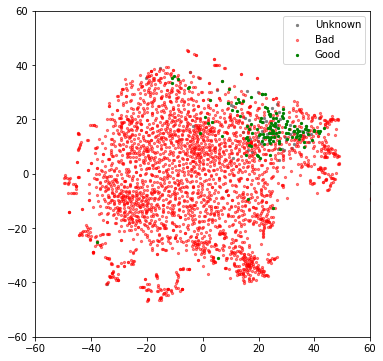

In [261]:
# Quickly visualise the embedding with good and bad candidates
fig, ax = plt.subplots(figsize=(6,6))
    
ax.scatter(X_tsne[:,0][unknown_mask], X_tsne[:,1][unknown_mask], 
                  c='grey', s=5, label='Unknown', zorder=1)

ax.scatter(X_tsne[:,0][bad_mask_all], X_tsne[:,1][bad_mask_all], 
                  c='red', s=5, label='Bad', zorder=2, alpha=0.5)

ax.scatter(X_tsne[:,0][good_mask_all], X_tsne[:,1][good_mask_all], 
                  c='green', s=5, label='Good', zorder=3)
ax.legend()
ax.set(xlim=(-60,60),ylim=(-60,60))
plt.show()

Clearly we have way more bad candidates than good here, and a very small unknown sample (that is actually labelled just other than O and K), it thus seems evident that we should reduce the sample. Since we will let the nearest neighbours vote, it is important that the density of labeled points is somewhat the same throughout the embedding for consistent results. Making a rough estimate it seems like the good object fill 1/8 of the area, so let's randomly sample the bad candidates so we end up with around 8 times more bad objects than good objects, and check that the density is somewhat consistent.

We will make a dataframe containing all the information we need to perform the semisupervised classification. Each row will be an object in the residual tab, the columns will contain:
x1: first coordinate in the tsne embedding
x2: second coordinate
Train_labels: labels that the algortihm will make its predictions from. Good objects are assigned 1, bad candidates 0, and unknown for the algorithm is assigned -1 (this includes the ones that are actually labelled that is used for the validation). Those assigned 0 and 1 here will be allowed to vote in the algortihm.
Val_labels: labels that we will compare with the predictions and calculate accuracy score from and produce a ROC curve. Again we use 1, 0 and -1 (here -1 )

To make the dataframe we first need to determine the train_labels and the val_labels. Afterwards we can combine them all in a pandas dataframe.

We also want a balanced validation set so we can estimate the accuracy more transparantly. That means we want as many bad objects as good objects in the validation set. As for the training set we want more bad objects since they fill a larger area of the clustering it seems.

In [269]:
# Set a random seed, so the results are reproducible
np.random.seed(1)

# Select a random sample of bad objects (a mask the size of the resiudal tab) 
#that continues labelled if i=True
prob = 8*np.sum(good_mask_all)/len(bad_objects_all)

bad_mask_sample = np.zeros(len(resi_tab), dtype=bool)
temp_mask = np.random.choice([True, False], size=np.sum(bad_mask_all), p=[prob,1-prob])
count = -1

for i in range(len(bad_mask_sample)):
    
    if bad_mask_all[i] == 1:
        count += 1
    
        if temp_mask[count] == 1:
            bad_mask_sample[i] = 1
        
# Make masks that divides the bad sample into train and val (a mask the size of resi_tab)
bad_train = np.zeros(len(resi_tab), dtype=bool)
bad_val = np.zeros(len(resi_tab), dtype=bool)
temp_mask = np.random.choice([True,False], size=np.sum(bad_mask_sample), p=[0.965, 0.035])
count = -1

for i in range(len(bad_train)):
    
    if bad_mask_sample[i] == 1:
        count += 1
        
        if temp_mask[count] == 1:
            bad_train[i] = 1
            
        if temp_mask[count] == 0:
            bad_val[i] = 1

# Specify ratio of train/val
train_size = 0.7
val_size = 1 - train_size

# Do the same for the good sample
good_train = np.zeros(len(resi_tab), dtype=bool)
good_val = np.zeros(len(resi_tab), dtype=bool)
temp_mask = np.random.choice([True, False], size=np.sum(good_mask_all), p=[train_size, val_size])
count = -1

for i in range(len(good_train)):
    
    if good_mask_all[i] == 1:
        count += 1
        
        if temp_mask[count] == 1:
            good_train[i] = 1
            
        if temp_mask[count] == 0:
            good_val[i] = 1
            
# Check lengths
print(f'We have {np.sum(bad_mask_sample)} bad objects and {np.sum(good_mask_all)} good objects in total')
print(f'Bad sample: {np.sum(bad_train)} is used for training, and {np.sum(bad_val)} is used for val')
print(f'Good sample: {np.sum(good_train)} is used for training, and {np.sum(good_val)} is used for val')

We have 1069 bad objects and 133 good objects in total
Bad sample: 1025 is used for training, and 44 is used for val
Good sample: 90 is used for training, and 43 is used for val


In [270]:
# Lets combine the information to make the train labels
train_lbl = -1*np.ones(len(resi_tab))
train_lbl[good_train] = 1
train_lbl[bad_train] = 0

# Same for val labels
val_lbl = -1*np.ones(len(resi_tab))
val_lbl[good_val] = 1
val_lbl[bad_val] = 0

# Lets crete the dataframe that contains all information
data = pd.DataFrame(np.column_stack((X_tsne, train_lbl, val_lbl)), 
                    columns=['x1','x2','Train_labels', 'Val_labels'], index=resi_tab['NUMBER'])
data

,x1,x2,Train_labels,Val_labels
NUMBER,,,,
192896,23.567003,-29.383211,-1.0,-1.0
193343,2.809530,-0.499929,-1.0,-1.0
193389,-3.297800,44.048283,0.0,-1.0
193704,1.208521,-10.862103,0.0,-1.0
194013,46.198071,-0.184139,0.0,-1.0
...,...,...,...,...
707738,2.877984,29.981203,0.0,-1.0
708077,-25.431675,20.577715,0.0,-1.0
708243,-32.589302,20.115812,-1.0,-1.0


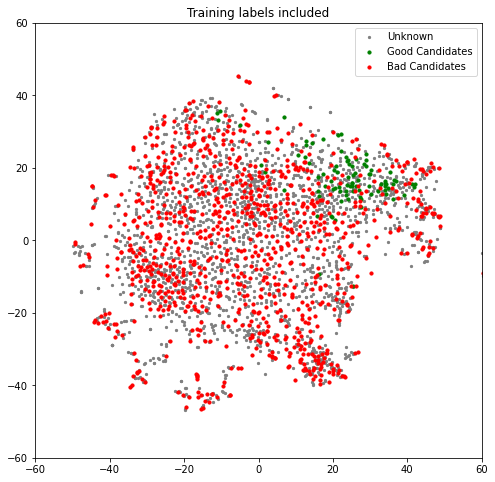

In [271]:
# Visualise the embedding with the training set of good and bad candidates

fig, ax = plt.subplots(figsize=(8,8))
    
ax.scatter(data['x1'][data['Train_labels']==-1], data['x2'][data['Train_labels']==-1],
          c = 'grey', s=5, label='Unknown') 

ax.scatter(data['x1'][data['Train_labels']==1], data['x2'][data['Train_labels']==1],
          c = 'green', s=10, label='Good Candidates') 

ax.scatter(data['x1'][data['Train_labels']==0], data['x2'][data['Train_labels']==0],
          c = 'red', s=10, label='Bad Candidates') 
    
ax.legend()
ax.set_title(f'Training labels included')
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)

plt.show()

This looks like a good sample to perform the voting on.

# Predictions with K voting

There are two way to chose neighbours:
1) letting the K nearest neighbour vote. This is likely more suited for a t-SNE plot that is in reality a hyperdimensional manifold where the euclidean distance is not necessarily the same in different regions of the embedding. This is similar to when you project a sphere onto a plane as we do with a world map, some continent will apear bigger than they actually are and some smaller. Using only the nearest neighbours will account for this. It does however need an assumption that our points is uniformly distributed (in the hyperplane), while this is not necessarily true, we do have a large representative sample so it should be an okay approximation. <br>
2) letting all neighbours within a radius r vote. Somewhat similar to what we did above.

We will explore option number one. When we have chosen K neighbours, we will let them vote. From this we will produce predictions. We do however need a parameter we can vary so we can produce a ROC curve, and so we can chose a cut suited for the purpose. This means we can chose which configuration to use if we want fewer samples but with next to no contamination. Or if we want a larger sample and don't care if there is a little contamination.

The parameter we will introduce is 'f_min', which is the fraction of votes from promising candidates needed before we make a prediction of a promising candidate. We will vary f_min between 0 and 1 and produce predictions.

## Defining the classification algorithm

In [329]:
def kNN_voting(k, f_min, dataframe):
    """
    k = int, number of nearest neighbours allowed to vote on the prediction
    f_min = the fraction of good votes needed for a 'good' prediction
    
    ----- updated to data containing all
    coords = array (n_samples, 2) containing the coordinates of the embedding for each point
    labels = labels of the provided number. 2 class prediction = 1 or 0. If the label is -1, 
             the point is unknown and will produce a prediction
    ----
    
    returns = array with predictions, len = number of labels==-1
    """
    
    # Number of unknown points
    n_unknown = np.sum(dataframe['Train_labels']==-1)
    
    # Make empty array for storing the class predictions on the unknown sample
    predictions = np.zeros(n_unknown)
    
    # Make empty array for storing the class predictions on what is the validation sample
    val_mask = (dataframe['Val_labels']!=-1)
    val_predictions = np.zeros(np.sum(val_mask))
    
    # Calculate distance from all unknown objects to all labeled objects (each row=one unknown point)
    d = cdist( dataframe.iloc[:,:2][dataframe['Train_labels']==-1], 
               dataframe.iloc[:,:2][dataframe['Train_labels']!=-1])
    
    count = -1
    
    # Loop over all unknown points
    for i in range(n_unknown):
        
        # Get the distances from the unknown point
        distances = d[i]
        
        # Get the sorted distance indexes, smallest to biggest distance
        sorted_idx = np.argsort(distances)
        
        # Get the indices of the k nearest neighbours
        neighbour_idx = sorted_idx[:k]
        
        # Get the labels of the k nearest labelled objects
        nearest_neighbours = dataframe['Train_labels'][dataframe['Train_labels']!=-1].to_numpy()[neighbour_idx]
        
        # Count the votes (remember bad are zero and 1 is good)
        n_good_votes = np.sum(nearest_neighbours)
        
        # Calculate fraction of good votes compared to bad votes
        good_fraction = n_good_votes / k
        
        # Save the prediction to the list of predictions (if bad wins it is already zero so no changes)
        if good_fraction >= f_min:
            predictions[i] = 1
            
            # Check if the point is in the validation sample
            if val_mask[dataframe['Train_labels']==-1].iloc[i] == True:
                count += 1
                val_predictions[count] = 1
            
    return predictions, val_predictions

## Making predictions

In [291]:
# Helper function to calculate rates needed for calculating FPR and TPR to be used in a ROC curve
def perf_measure(y_true, y_pred):
    
    # Start with zero so we can count from there
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1

    return (TP, FP, TN, FN)

In [399]:
# Specify which f_min to use
f_min_arr = np.linspace(0,1,100)

# Empty array to store stuff
accuracies = []
fpr_arr = []
tpr_arr = []
rates_arr = []
promising_fraction_arr = []

# Loop over f_min and produce predictions
for i in range(len(f_min_arr)):
    
    # Produce predictions
    pred_labels, val_pred = kNN_voting(15, f_min_arr[i], data)
    
    # Calculate accuracy
    acc = accuracy_score(data['Val_labels'][data['Val_labels']!=-1], pred_labels[get_val_pred_maske])
    accuracies.append(acc)
    
    # Calculate fraction of promising candidates predicted from val data
    promising_fraction = np.sum(val_pred) / len(val_pred)
    promising_fraction_arr.append(promising_fraction)
    
    # Performance measure
    rates = perf_measure(data['Val_labels'][data['Val_labels']!=-1].to_numpy(), pred_labels[get_val_pred_maske])
    rates_arr.append(rates)
    
    # Calculate FPR=FP/FP+TN
    FPR = rates[1]/(rates[1]+rates[2])
    fpr_arr.append(FPR)
    
    # Calculate TPR=TP/TP+FN
    TPR = rates[0]/(rates[0]+rates[3])
    tpr_arr.append(TPR)

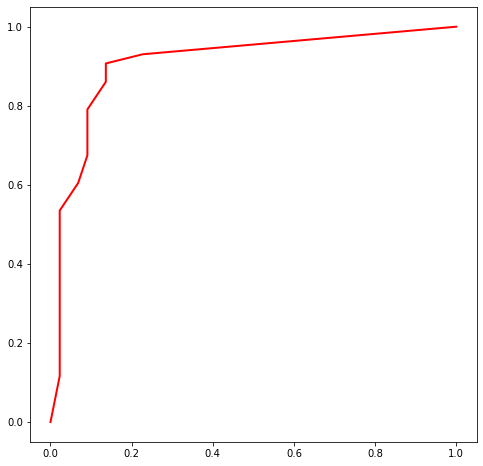

In [400]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(fpr_arr, tpr_arr, linewidth=2, color='red')

0.8850574712643678

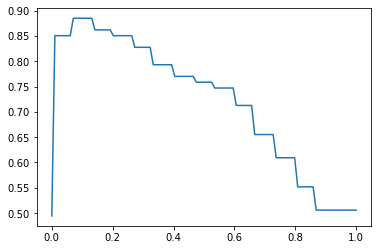

In [401]:
plt.plot(f_min_arr, accuracies)
np.max(accuracies)

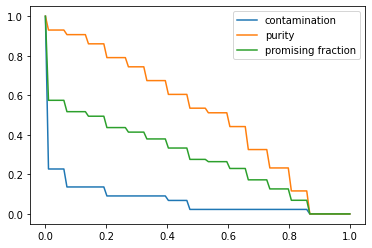

In [402]:
plt.plot(f_min_arr, fpr_arr, label='contamination') #FP/(TP+FP)
plt.plot(f_min_arr, tpr_arr, label='purity') #=TP/(TP+FP)
plt.plot(f_min_arr, promising_fraction_arr, label='promising fraction')
plt.legend()

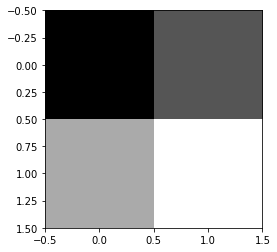

In [392]:
conf_mat = np.array([ [[1],[2]], [[3],[4]] ])
plt.imshow(conf_mat,cmap='gray')

In [283]:
# Make predictions
pred_labels_k5, val_pred_labels_k5 = kNN_voting(10, 0.1, data)

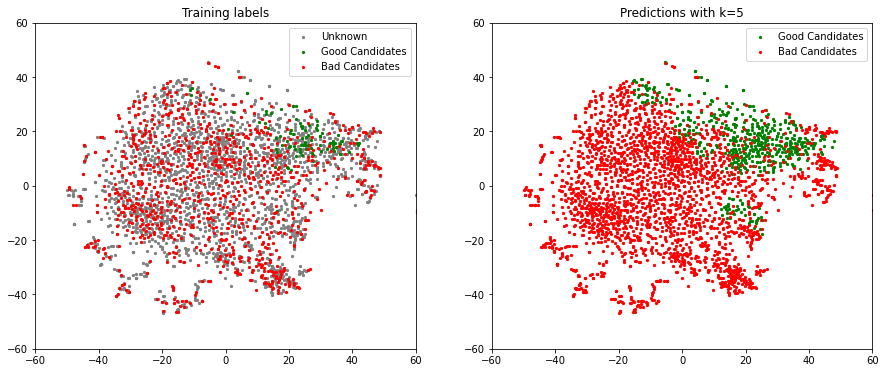

In [284]:
# Visualise results (train set keep their original label, everything else is plotted as their prediction

fig, ax = plt.subplots(ncols=2, figsize=(15,6))

# Plot training sample labels
ax[0].scatter(data['x1'][data['Train_labels']==-1], data['x2'][data['Train_labels']==-1],
              c = 'grey', s=5, label='Unknown') 

ax[0].scatter(data['x1'][data['Train_labels']==1], data['x2'][data['Train_labels']==1],
              c = 'green', s=5, label='Good Candidates') 

ax[0].scatter(data['x1'][data['Train_labels']==0], data['x2'][data['Train_labels']==0],
              c = 'red', s=5, label='Bad Candidates') 
    
# Plot the predictions
ax[1].scatter(data['x1'][data['Train_labels']==1], data['x2'][data['Train_labels']==1],
              c = 'green', s=5, label='Good Candidates') 
ax[1].scatter(data['x1'][data['Train_labels']==-1][pred_labels_k5==1], 
              data['x2'][data['Train_labels']==-1][pred_labels_k5==1], 
              c = 'green', s=5) 

ax[1].scatter(data['x1'][data['Train_labels']==0], data['x2'][data['Train_labels']==0],
              c = 'red', s=5, label='Bad Candidates') 
ax[1].scatter(data['x1'][data['Train_labels']==-1][pred_labels_k5==0], 
              data['x2'][data['Train_labels']==-1][pred_labels_k5==0],
              c = 'red', s=5) 
    
ax[0].legend()
ax[0].set_title(f'Training labels')
ax[0].set_xlim(-60,60)
ax[0].set_ylim(-60,60)

ax[1].legend()
ax[1].set_title(f'Predictions with k=5')
ax[1].set_xlim(-60,60)
ax[1].set_ylim(-60,60)

plt.show()

## Validating

In [285]:
# Extract the predicted values for the validation set
acc_k5 = accuracy_score(data['Val_labels'][data['Val_labels']!=-1], val_pred_labels_k5)
print(f'Accuracy: {acc_k5:2f}')

Accuracy: 0.540230


notes:
   prøv confusion matrix
   kig eventuel kun på hvor mange procent vi fik med og hvor rent smaplet er
   juster k
   juster hvor mange bad vi vælger at inddrager og val_size der

# Improving on the SED like plot

We want to plot the median magnitude as a function of wavelength, but since the flux is sometimes negative 
the magnitude is at times undefined since the object was to faint in that band to detect. 
(The detection was either performed in another band or i some kind of stacked image, I don't remember.)

We need to find the lowest threshold (highest magnitude detectable), and then we should choose whether to assign this first or after. 

Before we can do anything we need to define the areas we want to check. Let's workt with:
- (1) Bright stars
- (2) Matched stars
- (3) Promising candidaetes



In [ ]:
# Mark the areas we are talking about

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(X_tsne[:,0], X_tsne[:,1], s=5, c='g')

# Area 1
sq1 = Rectangle((55,-16), 20,16, fill=False, color='b',linewidth=2)
ax.add_artist(sq1)
ax.text(55,-20,'Area 1', color='b', fontsize=14)

# Area 2
sq2 = Rectangle((5,10), 50,30, fill=False,color='b', linewidth=2)
ax.add_artist(sq2)
ax.text(0,42,'Area 2', fontsize=14, color='b')

# Area 3
sq3 = Rectangle((-60,-20), 50,20, color='b', linewidth=2, fill=False)
ax.add_artist(sq3)
ax.text(-60,-25,'Area 3',fontsize=14,color='b')

ax.set_xlim(-80,80)
ax.set_ylim(-80,80)

plt.show()

In [ ]:
# Define ranges to select samples from according to boxes above

# Area 1:
xrange1, yrange1 = (55,75), (-16,0)

# Area 2:
xrange2, yrange2 = (5,55), (10,40)

# Area3:
xrange3, yrange3 = (-60,-10), (-20,0)

In [ ]:
# Make arrays containing only the subsamples

# Area 1:
mask1 = (X_tsne[:,0]>xrange1[0]) & (X_tsne[:,0]<xrange1[1]) \
        & (X_tsne[:,1]>yrange1[0]) & (X_tsne[:,1]<yrange1[1])
tab_a1 = resi_tab[mask1]

# Area 2:
mask2 = (X_tsne[:,0]>xrange2[0]) & (X_tsne[:,0]<xrange2[1]) \
        & (X_tsne[:,1]>yrange2[0]) & (X_tsne[:,1]<yrange2[1])
tab_a2 = resi_tab[mask2]

# Area 3:
mask3 = (X_tsne[:,0]>xrange3[0]) & (X_tsne[:,0]<xrange3[1]) \
        & (X_tsne[:,1]>yrange3[0]) & (X_tsne[:,1]<yrange3[1])
tab_a3 = resi_tab[mask3]

Remember that we found undefined values when calculating the magnitudes before. When calculating the mean magnitude in each band this will not be considered. We know that the highest magnitude (lowest brightness) it can detect is 26 mag (check Johns article to find the precise treshold), so we will use this as the upper limit on the magnitude and calculate a median that considers an upper limit. First however, we need to replace the undefined values with 26.

In [ ]:
# Get magnitudes for each object in each band in each area

# All area tabs in one list
tabs = [tab_a1, tab_a2, tab_a3]

# Tabs to save the list of magnitudes in
magnitudes_H = []
magnitudes_Ks = []
magnitudes_ch1 = []
magnitudes_ch2 = []

# Define upper limit of mag (see Weaver article)
H_upper_lim = 24.9
Ks_upper_lim = 25.3
ch1_upper_lim = 26.4
ch2_upper_lim = 26.3

# Get magnitudes
for i in range(3):
    
    # Calculate colors
    H_mag = -2.5*np.log10(tabs[i]['FLUX_APER_H'][:,0]) + uvista
    Ks_mag = -2.5*np.log10(tabs[i]['FLUX_APER_Ks'][:,0]) + uvista
    ch1_mag = -2.5*np.log10(tabs[i]['FLUX_APER_ch1'][:,0]) + irac
    ch2_mag = -2.5*np.log10(tabs[i]['FLUX_APER_ch2'][:,0]) + irac
    
    # Replace undefined values with upper limit
    H_mag = np.where(H_mag != np.isnan(H_mag), H_mag, H_upper_lim)
    Ks_mag = np.where(Ks_mag != np.isnan(Ks_mag), Ks_mag, Ks_upper_lim)
    ch1_mag = np.where(ch1_mag != np.isnan(ch1_mag), ch1_mag, ch1_upper_lim)
    ch2_mag = np.where(ch2_mag != np.isnan(ch2_mag), ch2_mag, ch2_upper_lim)
    
    # Replace to high values (not robust measurements) with upper limit
    H_mag = np.where(H_mag <= H_upper_lim, H_mag, H_upper_lim)
    Ks_mag = np.where(Ks_mag <= Ks_upper_lim, Ks_mag, Ks_upper_lim)
    ch1_mag = np.where(ch1_mag <= ch1_upper_lim, ch1_mag, ch1_upper_lim)
    ch2_mag = np.where(ch2_mag <= ch2_upper_lim, ch2_mag, ch2_upper_lim)
    
    # Append values
    magnitudes_H.append(H_mag)
    magnitudes_Ks.append(Ks_mag)
    magnitudes_ch1.append(ch1_mag)
    magnitudes_ch2.append(ch2_mag)

In [ ]:
# Plot SED plot
fig, ax = plt.subplots(figsize=(12,6))

# Define colors and to use
colors = ['b', 'g', 'r']
labels = ['Bright Sources', 'Promising Candidates', 'Matched Objects']

# Define wavelength for each band
Hx = 1.65
Ksx = 2.14
ch1x = 3.6
ch2x = 4.5

# Make grey boxes
size = 0.15
ax.vlines(Hx-size,20,30,color='k')
ax.vlines(Hx+size,20,30,color='k')

ax.vlines(Ksx-size,20,30,color='k')
ax.vlines(Ksx+size,20,30,color='k')

ax.vlines(ch1x-size,20,30,color='k')
ax.vlines(ch1x+size,20,30,color='k')

ax.vlines(ch2x-size,20,30,color='k')
ax.vlines(ch2x+size,20,30,color='k')

for i in range(3):
    
    # Plot magnitudes distributions
    ax.scatter(np.random.uniform(low=Hx-size, high=Hx+size, size=len(tabs[i])),
               magnitudes_H[i], s=10, c=colors[i], alpha=0.2)
    ax.scatter(np.random.uniform(low=Ksx-size, high=Ksx+size, size=len(tabs[i])), 
               magnitudes_Ks[i], s=10, c=colors[i], alpha=0.2)
    ax.scatter(np.random.uniform(low=ch1x-size, high=ch1x+size, size=len(tabs[i])), 
               magnitudes_ch1[i], s=10, c=colors[i], alpha=0.2)
    ax.scatter(np.random.uniform(low=ch2x-size, high=ch2x+size, size=len(tabs[i])), 
               magnitudes_ch2[i], s=10, c=colors[i], alpha=0.2)
    
    # Plot median magnitude with errorbar 25 and 75 percentile (implement kepler meier survival analysis)
    means = [np.median(magnitudes_H[i]), np.median(magnitudes_Ks[i]),
            np.median(magnitudes_ch1[i]), np.median(magnitudes_ch2[i])]
    errors = [np.std(magnitudes_H[i]), np.std(magnitudes_Ks[i]),
            np.std(magnitudes_ch1[i]), np.std(magnitudes_ch2[i])]
    ax.errorbar(x=[Hx,Ksx,ch1x,ch2x], y=means, yerr=errors, c=colors[i], linestyle='dashed',
               capsize=10, capthick=2, linewidth=2, label=labels[i])
    
# Make it prettay
ax.legend(prop={'size': 14},loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol=3)
ax.set_ylim(28,20)
ax.set_xlim(1.4,4.8)
ax.set_xlabel(r'Wavelength [$\mu$m]', fontsize=16)
ax.set_ylabel('Magnitude [mag]', fontsize=16)
ax.set_title('Median SED of Different Regions in the t-SNE Embedding',fontsize=18)
plt.xticks([1.65,2.14,3.6,4.5])

ax.set_facecolor('gainsboro')
plt.grid(color='white')


plt.show()
    
plt.show()

# Notes

In [ ]:
np.percentile(tab_a1['MAG_APER_Ks'][:,0], [25,75])

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Define colors and to use
colors = ['b', 'g', 'r']
labels = ['Bright sources', 'Promising Candidates', 'Matched Objects']
tabs = [tab_a1, tab_a2, tab_a3]

# Define wavelength for each band
Hx = 1.65
Ksx = 2.14
ch1x = 3.6
ch2x = 4.5

# Make grey boxes
size = 0.15
#ax.fill_between(x=[Hx-size,Hx+size], y1=50, y2=0, color='k', edgecolor='k', alpha=0.)
ax.vlines(Hx-size,20,30,color='k')
ax.vlines(Hx+size,20,30,color='k')
#ax.fill_between(x=[Ksx-size,Ksx+size], y1=50, y2=0, color='k', edgecolor=None, alpha=0.05)
ax.vlines(Ksx-size,20,30,color='k')
ax.vlines(Ksx+size,20,30,color='k')
#ax.fill_between(x=[ch1x-size,ch1x+size], y1=50, y2=0, color='k', edgecolor=None, alpha=0.05)
ax.vlines(ch1x-size,20,30,color='k')
ax.vlines(ch1x+size,20,30,color='k')
#ax.fill_between(x=[ch2x-size,ch2x+size], y1=50, y2=0, color='k', edgecolor=None, alpha=0.05)
ax.vlines(ch2x-size,20,30,color='k')
ax.vlines(ch2x+size,20,30,color='k')

for i in range(3):
    
    # Plot magnitudes distributions
    ax.scatter(np.random.uniform(low=Hx-size, high=Hx+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_H'][:,0], s=10, c=colors[i], alpha=0.2)
    
    ax.scatter(np.random.uniform(low=Ksx-size, high=Ksx+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_Ks'][:,0], s=10, c=colors[i], alpha=0.2)
    
    ax.scatter(np.random.uniform(low=ch1x-size, high=ch1x+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_ch1'][:,0], s=10, c=colors[i], alpha=0.2)
    
    ax.scatter(np.random.uniform(low=ch2x-size, high=ch2x+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_ch2'][:,0], s=10, c=colors[i], alpha=0.2)

    # Plot median magnitude with errorbar 25 and 75 percentile (implement kepler meier survival analysis)
    means = [np.median(tabs[i]['MAG_APER_H'][:,0]), np.median(tabs[i]['MAG_APER_Ks'][:,0]),
            np.median(tabs[i]['MAG_APER_ch1'][:,0]), np.median(tabs[i]['MAG_APER_ch2'][:,0])]
    errors = []
    ax.errorbar(x=[Hx,Ksx,ch1x,ch2x], y=means, yerr=np.ones(4)*1, c=colors[i], linestyle='dashed',
               capsize=10, capthick=1, linewidth=1, label=labels[i])
    
    
ax.legend(prop={'size': 10},loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol=3)
ax.set_ylim(30,20)
ax.set_xlim(1.4,4.8)
ax.set_xlabel(r'Wavelength [$\mu$m]', fontsize=12)
ax.set_ylabel('Magnitude [mag]', fontsize=12)
ax.set_title('Median SED of Different Regions in the t-SNE Embedding',fontsize=14)
plt.xticks([1.65,2.14,3.6,4.5]) #1.6, 2.2, 3.6, 4.5 microns
plt.show()

In [ ]:
plt.hist(resi_tab['MAG_APER_H'][:,0],bins=100)
plt.show()

It seems like the upper limit is just above 30. This should be implemented when calculating the median using a Kepler-Meier survival analysis.

In [ ]:
plt.hist( resi_tab['MAG_APER_H'][:,0][ resi_tab['MAG_APER_H'][:,0] < 50], bins=100)
plt.show()

In [ ]:
np.max(resi_tab['MAG_APER_H'][:,0][ resi_tab['MAG_APER_H'][:,0] < 50])